In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.train_utils import train, adv_train
from models.wide_resnet import WideResNet
from utils.attacks import pgd

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds = CIFAR10('../data', train=True, download=True, transform=tr_transform)
ds_test = CIFAR10('../data', train=False, download=True, transform=vl_transform)

batch_size = 150
train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### Wide-ResNet

**Natural training**

Epoch: 1 Validation Loss: 1.1561 accuracy: 0.5801, time: 0:05:36
Epoch: 2 Validation Loss: 0.9388 accuracy: 0.6722, time: 0:05:37
Epoch: 3 Validation Loss: 0.8065 accuracy: 0.7097, time: 0:05:45
Epoch: 4 Validation Loss: 0.7032 accuracy: 0.7506, time: 0:05:36
Epoch: 5 Validation Loss: 0.6512 accuracy: 0.7721, time: 0:05:37
Epoch: 6 Validation Loss: 0.5892 accuracy: 0.7918, time: 0:05:38
Epoch: 7 Validation Loss: 0.4901 accuracy: 0.8280, time: 0:05:37
Epoch: 8 Validation Loss: 0.4859 accuracy: 0.8317, time: 0:05:36
Epoch: 9 Validation Loss: 0.4568 accuracy: 0.8396, time: 0:05:36
Epoch: 10 Validation Loss: 0.4112 accuracy: 0.8585, time: 0:05:36
Epoch: 11 Validation Loss: 0.4045 accuracy: 0.8645, time: 0:05:35
Epoch: 12 Validation Loss: 0.4049 accuracy: 0.8622, time: 0:05:34
epochs_no_improve: 1/4
Epoch: 13 Validation Loss: 0.3744 accuracy: 0.8720, time: 0:05:33
Epoch: 14 Validation Loss: 0.3734 accuracy: 0.8688, time: 0:05:33
Epoch: 15 Validation Loss: 0.3370 accuracy: 0.8848, time: 0:05

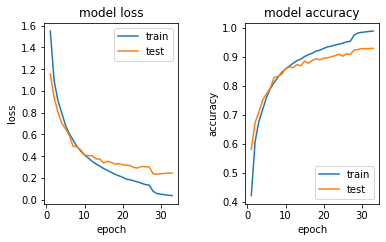

In [5]:
model = WideResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs=40, sparse=False, device=device)
torch.save(model.state_dict(), "../saved/wide_resnet.pt")

**Adversarial training**

In [6]:
attack_params = {
    "epsilon": 8/225,
    "alpha": 2/255,
    "num_iter": 10
}

In [7]:
model = WideResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10).to(device)
# model.load_state_dict(torch.load("../saved/wide_resnet.pt", map_location=device))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

adv_train(model, pgd, attack_params, train_dl, valid_dl, loss_fn, optimizer, scheduler,
          epochs=20, sparse=False, device=device)
torch.save(model.state_dict(), "../saved/robust_wide_resnet.pt")

Epoch: 1 Validation Loss: 1.4983 accuracy: 0.5250, time: 0:54:07
Epoch: 2 Validation Loss: 1.2788 accuracy: 0.6137, time: 0:54:06


KeyboardInterrupt: 